## This notebook should show the performance of the models performing the best in GridSearch.

In [ ]:
from drowsiness_detection import config

config.set_paths(30, 10)
import numpy as np
from drowsiness_detection.visualize import (plot_roc_over_sessions, plot_roc_over_subjects,
    plot_roc_over_n_folds)
from matplotlib import rcParams
from sklearn_evaluation import table
from drowsiness_detection.run_grid_search_experiment import base
from pprint import pprint
from sklearn.metrics import RocCurveDisplay
from sklearnex import patch_sklearn

patch_sklearn()
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv  # noqa
# now you can import normally from model_selection
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path
from drowsiness_detection import config
from sklearn.model_selection import StratifiedKFold

from drowsiness_detection.data import (session_type_mapping, get_feature_data,
    preprocess_feature_data)

rcParams["figure.figsize"] = 10, 10


In [18]:
config.set_paths(30, 10)

base_config = base()
pprint(base_config)

{'exclude_by': 'a',
 'grid_search_params': {'error_score': 0,
                        'factor': None,
                        'max_resources': None,
                        'n_jobs': -1,
                        'resource': None,
                        'scoring': None,
                        'shuffle': True,
                        'verbose': 1},
 'hyperparameter_specs': None,
 'model_name': None,
 'n_splits': 10,
 'recording_frequency': None,
 'seed': 123,
 'test_size': 0.2,
 'window_in_sec': None}


In [19]:
def load_pickle_object(filepath: Path):
    with open(filepath, "rb") as fp:
        return pickle.load(fp)


results_path = config.SOURCES_ROOT_PATH.parent.joinpath("logs")
ten_sec_model_path = results_path.joinpath("67/search_result.pkl")
twenty_sec_model_path = results_path.joinpath("69/search_result.pkl")
sixty_sec_model_path = results_path.joinpath("68/search_result.pkl")

model_paths = [ten_sec_model_path, twenty_sec_model_path, sixty_sec_model_path]

# result1 = load_pickle_object(ten_sec_model_path)
# result2 = load_pickle_object(twenty_sec_model_path)
# result3 = load_pickle_object(sixty_sec_model_path)

# model1 = load_pickle_object(ten_sec_model_path).best_estimator_
# model2 = load_pickle_object(twenty_sec_model_path).best_estimator_
# model3 = load_pickle_object(sixty_sec_model_path).best_estimator_
#
# models = [model1, model2, model3]
# models = [model1]


In [5]:
exclude_by = base_config.get("exclude_by")
seed = base_config.get("seed")
n_splits = base_config.get("n_splits")
shuffle = base_config.get("shuffle", True)



In [6]:
def load_train_test_splits(frequency, seconds):
    config.set_paths(frequency, seconds)
    data = get_feature_data(data_path=config.PATHS.WINDOW_FEATURES)
    X, y = preprocess_feature_data(feature_data=data, exclude_sess_type=session_type_mapping[
        base_config["exclude_by"]])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=base_config["test_size"],
                                                        random_state=base_config["seed"])
    return X_train, X_test, y_train, y_test


def dataset_generator():
    for seconds, model_path in zip([10, 20, 60], model_paths):
        model = load_pickle_object(model_path).best_estimator_
        yield (load_train_test_splits(30, seconds)), model

In [14]:
data_gen = dataset_generator()

#### Plot ROC of each model with the ROC Curve for each fold separately.
- on training data

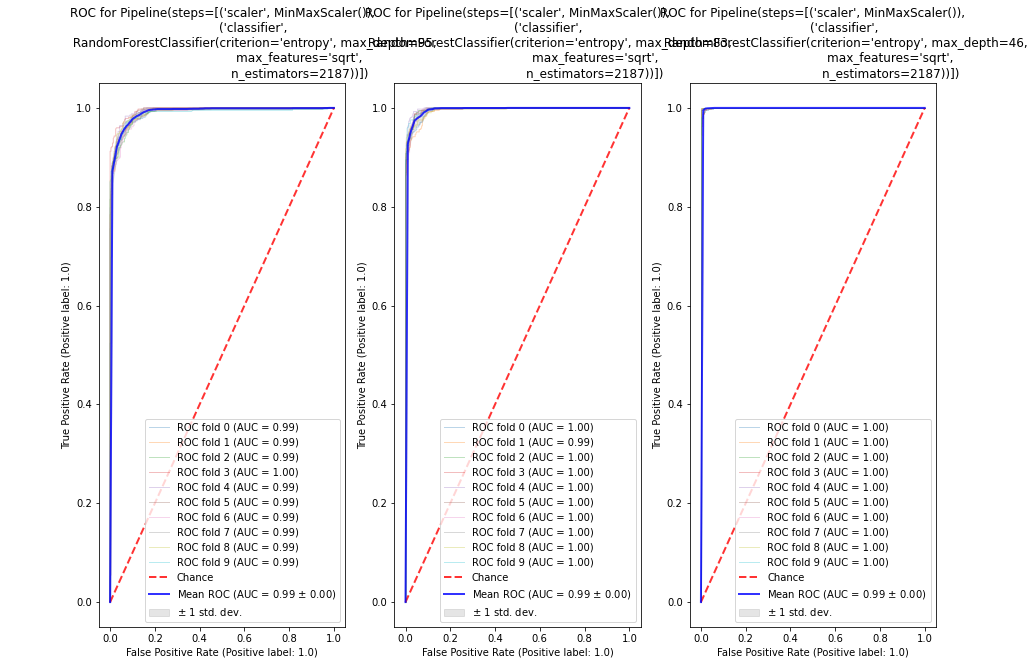

In [15]:
rcParams["figure.figsize"] = 15, 10
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
for ((X_train, X_test, y_train, y_test), model), ax in zip(data_gen, (ax1, ax2, ax3)):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=seed)
    plot_roc_over_n_folds(classifier=model, X=X_train, y=y_train, cv=cv, ax=ax)


In [22]:
# validate accuray on test set
data_gen = dataset_generator()
i  = 1
for (X_train, X_test, y_train, y_test), model in data_gen:
    y_hat = model.predict(X_test)
    print(f"Test-Accuracy for model {i}: \n", np.mean(y_hat == y_test))
    y_hat = model.predict(X_train)
    print(f"Train-Accuracy for model {i}: \n", np.mean(y_hat == y_train))
    i += 1

Test-Accuracy for model 1: 
 0.9444602677299915
Train-Accuracy for model 1: 
 0.9513602050989888
Test-Accuracy for model 2: 
 0.9632044038823699
Train-Accuracy for model 2: 
 0.9619327031040603
Test-Accuracy for model 3: 
 0.992221530802738
Train-Accuracy for model 3: 
 0.9924926093044967


In [ ]:
data_gen = dataset_generator()
i  = 1
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
for ((X_train, X_test, y_train, y_test), model), ax in zip(data_gen, (ax1, ax2, ax3)):
    RocCurveDisplay.from_estimator(model, X=X_test, y=y_test, ax=ax)
plt.show()


In [1]:
1

1

#### Plot ROC of each model with the ROC Curve on the data for each session separately.
- on test data

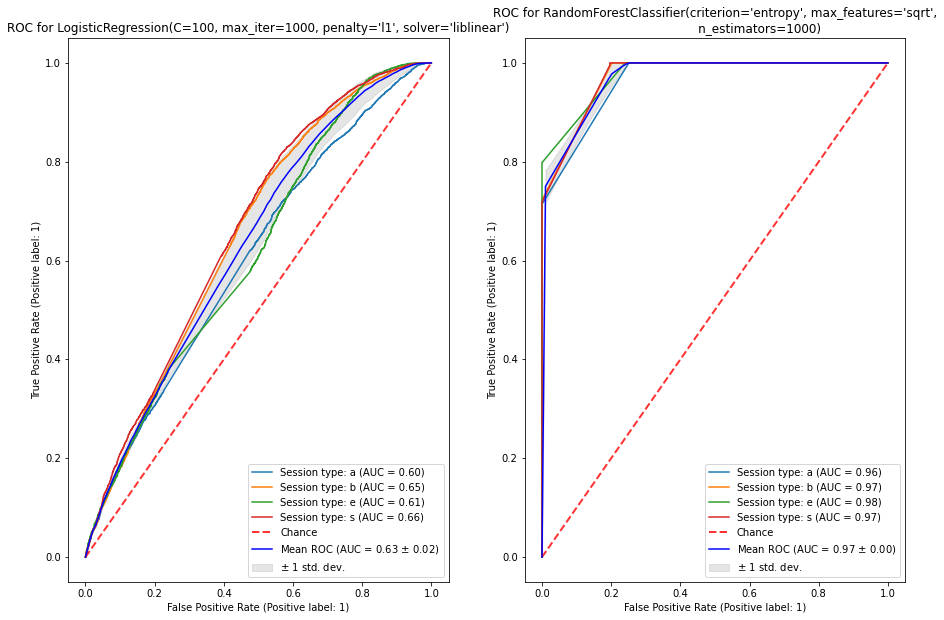

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2)
plot_roc_over_sessions(classifier=log_regression, identifiers=ids, X=X, y=y, ax=ax1)
plot_roc_over_sessions(classifier=random_forest, identifiers=ids, X=X, y=y, ax=ax2)
rcParams["figure.figsize"] = 15, 10
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
for ((X_train, X_test, y_train, y_test), model), ax in zip(data_gen, (ax1, ax2, ax3)):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=seed)
    plot_roc_over_n_folds(classifier=model, X=X_test, y=y_test, cv=cv, ax=ax)

#### Plot ROC of each model with the ROC Curve for each subject separately.
- on test data


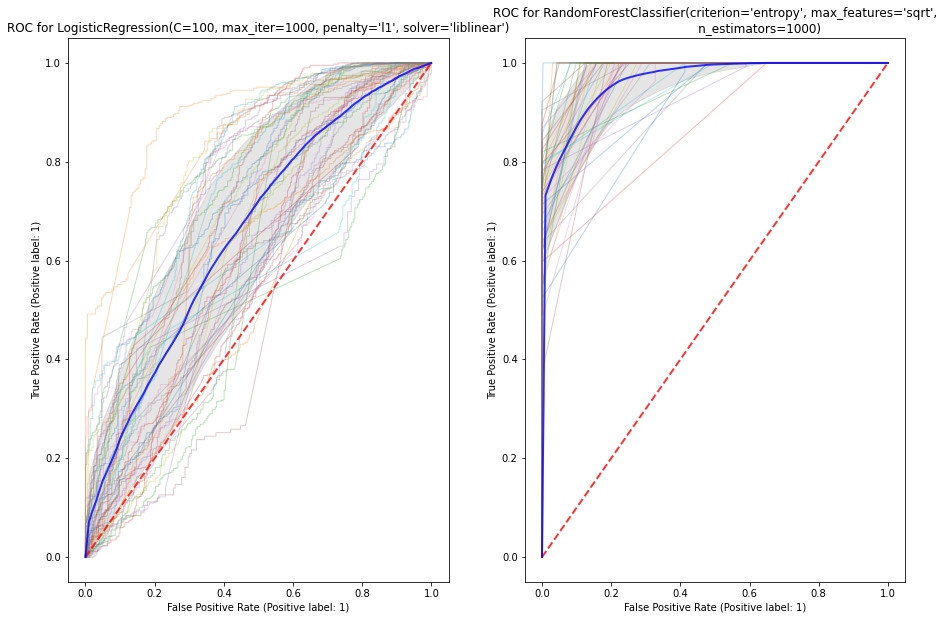

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2)
plot_roc_over_subjects(classifier=log_regression, identifiers=ids, X=X, y=y, ax=ax1)
plot_roc_over_subjects(classifier=random_forest, identifiers=ids, X=X, y=y, ax=ax2)


In [28]:
table.feature_importances(data=random_forest.feature_importances_, top_n=30,
                          feature_names=FEATURE_NAMES)

feature_name,importance
_median_-AVR,0.0331056
_mean_-AVR,0.0330545
_mean_closure_speed_mean,0.0292902
_mean_standard_lid_reopening_durations,0.0292319
_mean_standard_closure_speed_mean,0.0291273
_mean_standard_blink_duration,0.0285246
_median_+AVR,0.0280357
_median_closure_speed_mean,0.0280239
_median_standard_closure_speed_mean,0.0278234
_mean_+AVR,0.027765


In [36]:
table.feature_importances(data=log_regression.coef_[0], feature_names=FEATURE_NAMES)

feature_name,importance
_mean_closure_speed_max,8.88728
_median_closure_speed_max,6.08545
_std_closure_speed_max,5.93541
_median_standard_closure_speed_mean,5.54378
_mean_standard_closure_speed_mean,5.07528
LC,1.97772
_kurtosis_standard_closure_speed_mean,1.03265
_kurtosis_closure_speed_max,0.85453
_skew_closure_speed_mean,0.615929
_skew_standard_closure_speed_max,0.114306


In [35]:
log_regression.coef_.shape

(1, 67)